## Section 3

1.  Creating PPI Network as an alternate to Gene correlation
    - From the EWAS Catalog get a list of CpG sites and genes relating to smoking
    - Subset to matching CpG sites in the methylation data
    - Swap CpG sites to corresponding Gene (obtained from EWAS)
    - Generate smoking "disease" PPI network from StringDB
    - Build a data graph dataset which incorporates the Gen Scot methylation data
2.  Functional Enrichment Analysis (GSEApy)
    - On Gene Correlation Network
    - Perform on PPI network
    - Comparison
      - Results in population samples is supported by evidence in literature from stringdb
3.  Clustering methods
    - nx.clustering_communities
    - functional enrichment of clusters
4.  Bootstrapping + others

- make sure to explain each concepts + datasets (in the talk) and move onto coding session
- emptying out ### YOUR CODE HERE ###
  - 

In [2]:
import pickle
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plt.rcParams['figure.figsize'] = [5, 3] 

### 0. Load Datasets

In [3]:
gen_scot = pd.read_pickle('/Users/chaeeunlee/Documents/VSC_workspaces/ismb_2024_data/ISMB_GS_Data.pkl')
# use JSON instead
ewas_smoking = pd.read_csv('smoking.tsv' , delimiter='\t') # Epigenome-Wide Association Study (EWAS) smoking data. (https://www.ewascatalog.org/?trait=smoking)

print(gen_scot.keys())
print(ewas_smoking.columns)

dict_keys(['DNAm_w1', 'DNAm_w3', 'Phenotypes'])
Index(['author', 'consortium', 'pmid', 'date', 'trait', 'efo', 'analysis',
       'source', 'outcome', 'exposure', 'covariates', 'outcome_unit',
       'exposure_unit', 'array', 'tissue', 'further_details', 'n', 'n_studies',
       'age', 'sex', 'cpg', 'chrpos', 'chr', 'pos', 'gene', 'type', 'beta',
       'se', 'p', 'details', 'study_id'],
      dtype='object')


### 1. Create Protein-Protein Interaction (PPI) Network

In [4]:
ewas_smoking = pd.read_csv('smoking.tsv' , delimiter='\t') # https://www.ewascatalog.org/?trait=smoking
ewas_smoking.columns

# explain EWAS

Index(['author', 'consortium', 'pmid', 'date', 'trait', 'efo', 'analysis',
       'source', 'outcome', 'exposure', 'covariates', 'outcome_unit',
       'exposure_unit', 'array', 'tissue', 'further_details', 'n', 'n_studies',
       'age', 'sex', 'cpg', 'chrpos', 'chr', 'pos', 'gene', 'type', 'beta',
       'se', 'p', 'details', 'study_id'],
      dtype='object')

In [5]:
ewas_smoking = ewas_smoking[['cpg', 'gene']] # Select only the 'cpg' and 'gene' columns.
ewas_smoking = ewas_smoking[ewas_smoking['gene'] != '-'] # Filter out rows with invalid gene names.
ewas_smoking = ewas_smoking.drop_duplicates() # Remove duplicate rows from the dataframe to ensure each CpG site-gene pair is unique.
ewas_smoking = ewas_smoking.set_index('cpg') # Set the 'cpg' column as the index.

# patient similarity network, feature selection with regression, EWAS is still molecular but from patient study
# ASD gene expression at Seb's section (GEO, ) -> 
# multimodal -> gene expression, methylation 
# 500 patient gene expression -> 
# patient network based on gene expression (-> PPI ), patient network based on methylation -> clustering. -> fuse two patient networks?
# if you cluster on patient how do you enrich. 
# 

In [6]:
# Load and drop missing values from DNA methylation data w1 and w3 -> two diff batches
w1 = gen_scot['DNAm_w1'].dropna()
w3 = gen_scot['DNAm_w3'].dropna()
phenotypes = gen_scot['Phenotypes']

# Identify common CpG sites present in both GenScot W1 and W3 data and another EWAS smoking dataset.
common_cpg = list(set(w1.index) & set(w3.index) & set(ewas_smoking.index))
w1 = w1.loc[common_cpg]  # Filter W1 data to include only common CpG sites.
w3 = w3.loc[common_cpg]  # Filter W3 data similarly.
ewas_smoking = ewas_smoking.loc[common_cpg]  # Filter EWAS smoking data similarly.

# Helper function to categorize smoking status based on pack_years. -> explain pack_years, examples
def smoking_cat(pack_years):
    if pack_years == 0: # maybe a diff threshold
        return 'Never'
    else:
        return 'Smoker'

# Apply to GenScot phenotypes data.
phenotypes['Smoking'] = phenotypes['pack_years'].apply(smoking_cat)

# Prepare phenotype data for W1 cohort.
phenotypes_w1 = phenotypes.set_index('Sample_SentrixID') 
phenotypes_w1 = phenotypes_w1[phenotypes_w1['Smoking'].notna()]  # Drop entries without smoking data.
phenotypes_w1 = phenotypes_w1[phenotypes_w1['Set'] == 'W1']  # Select only entries from W1 set.

# Align W1 methylation data and W1 phenotype data on common indices.
common_idx = list(set(w1.columns) & set(phenotypes_w1.index))
w1 = w1.loc[:, common_idx]  # Select common columns for W1 methylation data.
phenotypes_w1 = phenotypes_w1.loc[common_idx]  # Select common indices for W1 phenotypes.

# Prepare phenotype data for W3 cohort similarly.
phenotypes_w3 = phenotypes.set_index('Sample_SentrixID')
phenotypes_w3 = phenotypes_w3[phenotypes_w3['Smoking'].notna()]
phenotypes_w3 = phenotypes_w3[phenotypes_w3['Set'] == 'W3']

# Align W3 methylation data and W3 phenotype data on common indices.
common_idx = list(set(w3.columns) & set(phenotypes_w3.index))
w3 = w3.loc[:, common_idx]
phenotypes_w3 = phenotypes_w3.loc[common_idx]


#### 1.2 Retrieve PPI data from StringDB

In [7]:
def get_PPIs(identifiers, qtype="get_network"):
    
    identifiers = '%0D'.join(map(str, identifiers))  # Concatenate using '%0D' for the API query.
    query_templates = {
        # "get_string_id": f"https://string-db.org/api/tsv-no-header/get_string_ids?identifiers={identifiers}&species=9606&format=only-ids",
        "get_network": f"https://string-db.org/api/tsv/network?identifiers={identifiers}&species=9606",
        # "get_annotation": f"https://string-db.org/api/json/functional_annotation?identifiers={identifiers}", # &[optional_parameters]"
    }
    
    query_url = query_templates[qtype]
    result = ul.request.urlopen(query_url).read().decode('utf-8').splitlines()
    
    return result

def get_stringdb_ids(identifiers, return_list=False):
    
    identifiers = '%0D'.join(map(str, identifiers)) # Concatenate using '%0D' for the API query.
    query_url = f"https://string-db.org/api/tsv-no-header/get_string_ids?identifiers={identifiers}&species=9606&format=only-ids"
    result = ul.request.urlopen(query_url).read().decode('utf-8').splitlines()
    # result = '%0D'.join(result)
    
    return result if return_list else '%0D'.join(result)

In [8]:
# PPIs related to the genes of interest derived from the EWAS smoking data.
PPIs_df = pd.DataFrame()

# The genes are grouped, sorted by frequency, and the top 400 are selected.
ewas_smoking_genes = list(ewas_smoking.groupby('gene').size().sort_values(ascending=False).iloc[:200].index)

# Get String-DB IDs for the list of gene names.
stringdb_ids = get_stringdb_ids(ewas_smoking_genes, return_list=True)

# Retrieve PPI data using the String-DB IDs.
interactions = get_PPIs(stringdb_ids, qtype="get_network")
interactions = [interaction.split('\t') for interaction in interactions] # Process the interaction data.

# Extract column names and create a DataFrame.
column_names = interactions[0]  # Assuming the first line contains header information.
interactions_df = pd.DataFrame(interactions[1:], columns=column_names)  # Exclude header from data rows.

# Remove any duplicate rows and reset the DataFrame index.
interactions_df.drop_duplicates(inplace=True)
interactions_df.reset_index(drop=True, inplace=True)

# Concatenate with any existing interactions DataFrame to accumulate results.
PPIs_df = pd.concat([PPIs_df, interactions_df], ignore_index=True)

# Display the top rows of the protein-protein interaction table.
display(PPIs_df.head())
display(PPIs_df.info())


,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000206513,9606.ENSP00000496959,CEBPE,ITGAM,9606,0.455,0,0,0,0.123,0.048,0,0.4
1,9606.ENSP00000206513,9606.ENSP00000368632,CEBPE,GATA3,9606,0.473,0,0,0,0,0.091,0,0.444
2,9606.ENSP00000206513,9606.ENSP00000345344,CEBPE,CTSL,9606,0.528,0,0,0,0.104,0,0,0.495
3,9606.ENSP00000206513,9606.ENSP00000294702,CEBPE,GFI1,9606,0.638,0,0,0,0.126,0.091,0,0.581
4,9606.ENSP00000206513,9606.ENSP00000254066,CEBPE,RARA,9606,0.863,0,0,0,0.057,0.045,0.75,0.465


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stringId_A       272 non-null    object
 1   stringId_B       272 non-null    object
 2   preferredName_A  272 non-null    object
 3   preferredName_B  272 non-null    object
 4   ncbiTaxonId      272 non-null    object
 5   score            272 non-null    object
 6   nscore           272 non-null    object
 7   fscore           272 non-null    object
 8   pscore           272 non-null    object
 9   ascore           272 non-null    object
 10  escore           272 non-null    object
 11  dscore           272 non-null    object
 12  tscore           272 non-null    object
dtypes: object(13)
memory usage: 27.8+ KB


None

In [9]:
# Make sure PPIs returned from String-DB correspond to the genes in the EWAS smoking data.
gene_set = set(ewas_smoking['gene'])

mask = PPIs_df.apply(lambda row: (row['preferredName_A'] in gene_set) and (row['preferredName_B'] in gene_set), axis=1)
PPIs_df = PPIs_df[mask]

PPIs_df.reset_index(drop=True, inplace=True)

#### 1.3 Create PPI Network Using `networkx`

In [10]:
import networkx as nx  # Import the networkx library to handle graph operations

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
# We extract unique names from both 'preferredName_A' and 'preferredName_B' and add them as nodes in the graph.
nodes = set(PPIs_df['preferredName_A']).union(set(PPIs_df['preferredName_B']))
G.add_nodes_from(nodes)

# Add edges to the graph
# We create a list of tuples where each tuple represents a connection (edge) between two nodes.
edges = list(zip(PPIs_df['preferredName_A'], PPIs_df['preferredName_B']))
G.add_edges_from(edges)  # Add all edges to the network


Helper functions to draw networks

In [11]:
def draw_network(G, figsize=(8, 8)):
    
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(G, k=2)  
    nx.draw(G, pos=pos, with_labels=True, node_size=100, edge_color='gray', node_color='lightblue', width=0.5)
    plt.show()

def draw_weighted_network(G, attr_name, figsize=(8, 8)):
    
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=2)

    # Extract edge weights based on attr_name
    edge_weights = [data[attr_name] for _, _, data in G.edges(data=True)]

    # Normalize edge weights for visualization
    max_weight = max(edge_weights)
    normalized_weights = [float(weight) / float(max_weight) for weight in edge_weights]

    # Draw edges with thickness reflecting weights
    for (node1, node2, data), weight in zip(G.edges(data=True), normalized_weights):
        nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)], width=weight, edge_color='gray')

    nx.draw(G, pos=pos, with_labels=True, node_size=100, node_color='lightblue')
    plt.show()


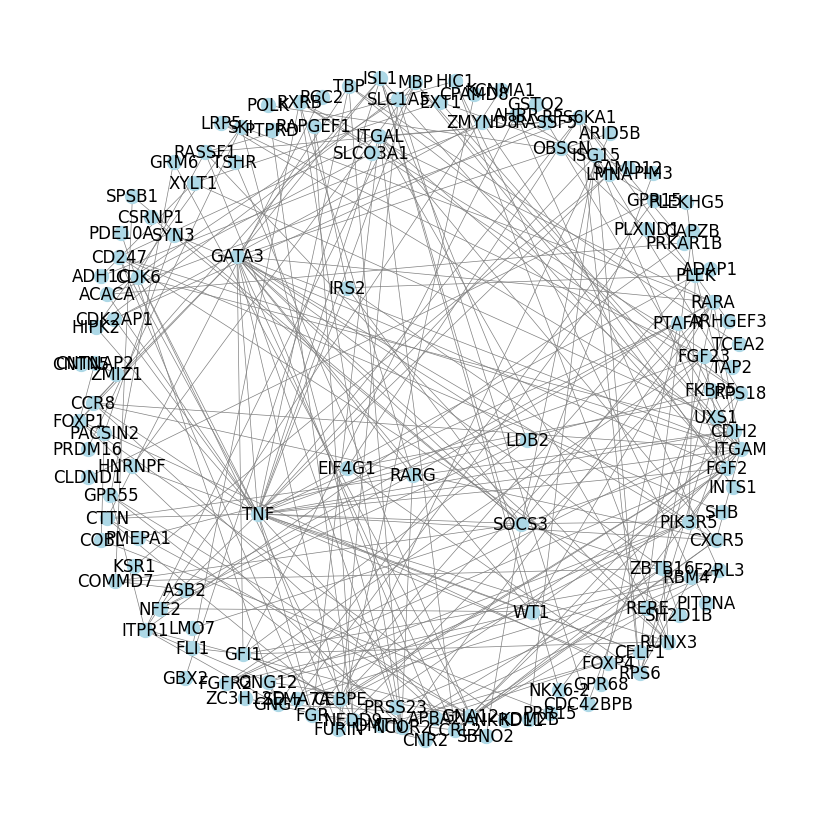

In [12]:
draw_network(G)

##### Sparsification on unweighted network

do some thresholding (sparsification) and use that later in the notebook to do some analysis.

- methylation for weights would be ideal
- PPI scores 
- KNN

Node Degree

In [13]:
# Sort the genes (node names) by degree
sorted_list = sorted(G.degree(), key=lambda item: item[1] , reverse=True)

# Print out the top 10 using
x = PrettyTable()
x.field_names = ["Gene","Degree"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

+--------+--------+
|  Gene  | Degree |
+--------+--------+
|  TNF   |   30   |
| GATA3  |   19   |
| ITGAM  |   17   |
| SOCS3  |   14   |
|  FGF2  |   12   |
| GNA12  |   10   |
|  RARA  |   10   |
|  PLEK  |   10   |
| NCOR2  |   10   |
| ZBTB16 |   9    |
+--------+--------+


Closeness Centrality

In [14]:
# Sort the genes (node names) by proximity to center
sorted_list = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1] , reverse=True) 

# Print out the top 10
x = PrettyTable()
x.field_names = ["Gene","Closeness"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

+-------+---------------------+
|  Gene |      Closeness      |
+-------+---------------------+
|  TNF  |  0.4409731041684306 |
| GATA3 |  0.3968757937515875 |
| ITGAM | 0.39307187240572566 |
| SOCS3 | 0.36616516685414324 |
|  FGF2 |  0.3586924083469158 |
| CXCR5 |  0.3586924083469158 |
| RUNX3 | 0.35353878179020726 |
| CCRL2 |  0.3495212956335004 |
|  CDH2 |  0.3475465990480004 |
|  MBP  |  0.3475465990480004 |
+-------+---------------------+


Clustering Coefficient
- couple slides for clustering methods
  - specific methods
    - communities clustering

In [15]:
# Sort the genes (node names) by clustering coefficient
sorted_list = sorted(nx.clustering(G).items(), key=lambda item: item[1] , reverse=True)

# Print out the top 10 
x = PrettyTable()
x.field_names = ["Gene","Clustering"]
for gene in sorted_list[:10]:
    x.add_row(gene)
print(x)

+--------+--------------------+
|  Gene  |     Clustering     |
+--------+--------------------+
| SPSB1  |        1.0         |
| ARID5B |        1.0         |
| APBA2  |        1.0         |
| NKX6-2 |        1.0         |
|  CCR8  |        1.0         |
|  GRM6  |        1.0         |
| EIF4G1 | 0.6666666666666666 |
| CXCR5  | 0.6190476190476191 |
|  FGR   | 0.6190476190476191 |
| CCRL2  | 0.6071428571428571 |
+--------+--------------------+


Visualization

In [16]:
G_sparse = nx.Graph(G)  # Create a copy of the original graph

# Calculate closeness centrality for each node (gene) in the graph
closeness_centralities = nx.closeness_centrality(G)

# Remove nodes with closeness centrality less than 0.3
low_centrality_nodes = [gene for gene, centrality in closeness_centralities.items() if centrality < 0.3]
G_sparse.remove_nodes_from(low_centrality_nodes)

# Calculate degrees of the remaining nodes after the centrality-based removal
degrees = dict(G.degree())

# Remove nodes with degree less than 3
low_degree_nodes = [gene for gene, degree in degrees.items() if degree < 3]
G_sparse.remove_nodes_from(low_degree_nodes)

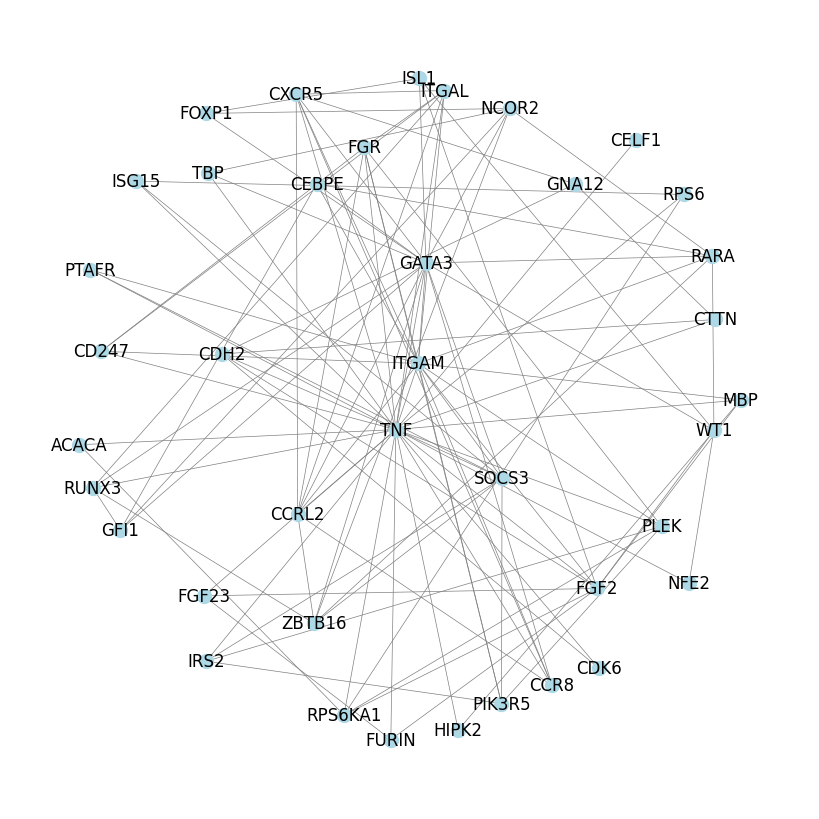

In [17]:
draw_network(G_sparse)

In [18]:
# import community as community_louvain
# communities = community_louvain.best_partition(G)


# communities = nx.algorithms.community.girvan_newman(G)
# communities = next(communities)

# number_of_communities = 5
# communities = nx.algorithms.community.asyn_fluidc(G, number_of_communities)


# communities = list(nx.algorithms.community.label_propagation_communities(G))

# k = 5  # Clique size
# communities = list(nx.algorithms.community.k_clique_communities(G, k))

Modularity clustering algorithm

In [19]:
# Cluster with networkx modularity clustering algorithm


# simple comparison of two 
# heatmap between the two clustering methods. 
# k means hierarchical
# one of the modularity emthods
# in the morning lecture 
# explaining 
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

# print the number of communities
print('The network has '+str(len(communities))+' communities.\n')

# create sub-grpahs for each community
subgraphs = []
for community in communities:
    subgraphs.append(G.subgraph(community))
    
# print the number of nodes in each community
for i, subgraph in enumerate(subgraphs):
    print('Community '+str(i+1)+' has '+str(subgraph.number_of_nodes())+' nodes.')

The network has 11 communities.

Community 1 has 24 nodes.
Community 2 has 24 nodes.
Community 3 has 17 nodes.
Community 4 has 13 nodes.
Community 5 has 12 nodes.
Community 6 has 12 nodes.
Community 7 has 10 nodes.
Community 8 has 7 nodes.
Community 9 has 4 nodes.
Community 10 has 3 nodes.
Community 11 has 2 nodes.


In [20]:
len(list(G.nodes())) # this comes from 200 gene names queried from String-DB <- save to json file

# 50+ nodes in each community ideally, or make the initial graph bigger

128

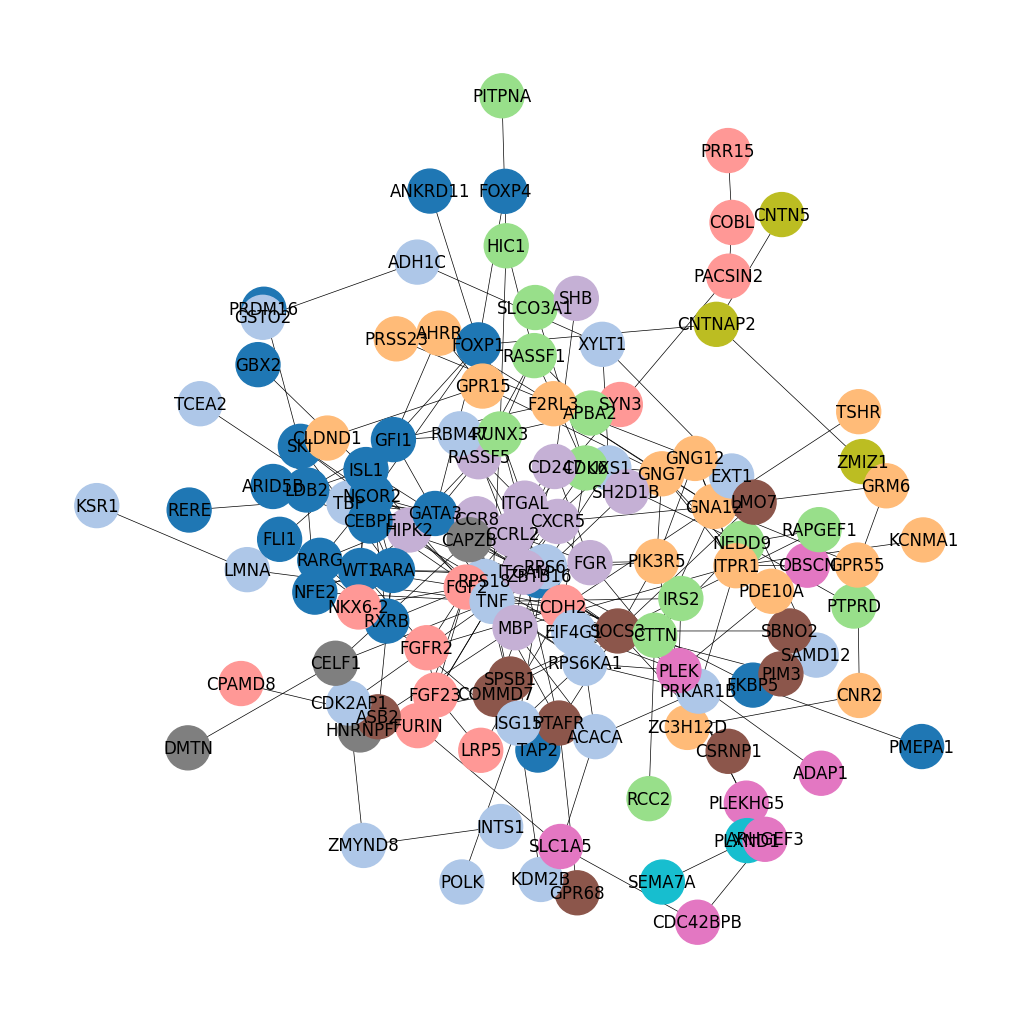

In [21]:
# Create a dict with the gene_id as key and community membership list as value
communityDict = dict()

# Loop through the communities
for i, community in enumerate(communities):
    # Loop through the diseases in the community
    for gene_id in community:
        # Add the disease and community to the dictionary
        communityDict[gene_id] = i


num_communities = len(communities)  
cmap = plt.get_cmap('tab20')  # 'tab20' has 20 distinct colors
communityColours = [cmap(i/num_communities) for i in range(num_communities)]
nodeColours = [communityColours[communityDict[node]] for node in G.nodes()]

# Create a list of the node labels
nodeLabels = {node:node for node in G.nodes()}

plt.figure(figsize=(10,10))

# Draw the graph separating nodes by their community

pos = nx.spring_layout(G, k=0.2, iterations=30, scale=1.5) # use diff layouts 
nx.draw(G, pos, node_color=nodeColours, with_labels=True, node_size=1000, font_size=12, width=0.5)

#### Over-Representation Analysis (ORA)

In [22]:
gene_sets = 'KEGG_2019_Human' # 'MSigDB_Hallmark_2020' # maybe briefly explain

# some validation to make sure gene ids we're using vs those from KEGG are identical. -> how many genes are mapped correctly?
# check if gseapy has that functionality 

# Create a separate gene list from communityDict dictionary for each community
community1_genes = []
community2_genes = []
community3_genes = []

# Loop through the dictionary
for gene_id, community in communityDict.items():
    # add the gene to the appropriate community list
    if community == 0:
        community1_genes.append(gene_id)
    elif community == 1:
        community2_genes.append(gene_id)
    elif community == 2:
        community3_genes.append(gene_id)

def communityORA(genes):
    # Perform ORA against the Hallmark gene sets for each community
    enr = gp.enrichr(gene_list=genes, # perform enrichment analysis using gsea
                    gene_sets=[gene_sets],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    )
    return enr

# Perform ORA for each community
community1_enr = communityORA(community1_genes)
community2_enr = communityORA(community2_genes)
community3_enr = communityORA(community3_genes)

# Print the top 10 results for each community
x = PrettyTable()
x.field_names = ["Community 1","Community 2","Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i],community2_enr.results['Term'][i],community3_enr.results['Term'][i]])
print(x)

# ORA's just a bionomial test not using GSEA approach. we're simply using the package

# in the end we wouldn't want to use ORA

+-----------------------------------------------------+----------------------------------------------+-------------------------------------------------+
|                     Community 1                     |                 Community 2                  |                   Community 3                   |
+-----------------------------------------------------+----------------------------------------------+-------------------------------------------------+
|       Transcriptional misregulation in cancer       |          Insulin signaling pathway           |               Cholinergic synapse               |
|                Acute myeloid leukemia               |            mTOR signaling pathway            |              Glutamatergic synapse              |
|              Th17 cell differentiation              |         Epstein-Barr virus infection         |             Apelin signaling pathway            |
| Parathyroid hormone synthesis, secretion and action |        Glycosaminoglycan b

In [23]:
enr_all_nodes = gp.enrichr(gene_list=list(G.nodes()), # perform enrichment analysis using gsea
                    gene_sets=[gene_sets],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    )

In [24]:
enr_all_nodes.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Pathways in cancer,17/530,4.938192e-08,0.000009,0,0,5.779516,97.232742,GSTO2;ZBTB16;PLEKHG5;LRP5;GNG12;FGF2;RXRB;RASSF1;CDK6;GNG7;RASSF5;GNA12;RARA;POLK;FGF23;FGFR2;F2RL3
1,KEGG_2019_Human,Epstein-Barr virus infection,9/201,5.944763e-06,0.000556,0,0,7.752101,93.281029,NCOR2;CDK6;TAP2;ISG15;CD247;POLK;ITGAL;RUNX3;TNF
2,KEGG_2019_Human,Transcriptional misregulation in cancer,8/186,2.659660e-05,0.001658,0,0,7.376030,77.704463,RXRB;ITGAM;WT1;CEBPE;ZBTB16;RARA;POLK;FLI1
3,KEGG_2019_Human,Rap1 signaling pathway,8/206,5.494959e-05,0.002023,0,0,6.624242,64.977819,ITGAM;RASSF5;RAPGEF1;ITGAL;FGF23;FGF2;FGFR2;F2RL3
4,KEGG_2019_Human,"Parathyroid hormone synthesis, secretion and action",6/106,6.176679e-05,0.002023,0,0,9.723934,94.245779,RXRB;GNA12;ITPR1;LRP5;GATA3;FGF23
5,KEGG_2019_Human,Non-small cell lung cancer,5/66,6.489912e-05,0.002023,0,0,13.202053,127.303122,RXRB;RASSF1;CDK6;RASSF5;POLK
6,KEGG_2019_Human,Ras signaling pathway,8/232,1.257998e-04,0.003361,0,0,5.847619,52.516409,RASSF1;KSR1;GNG7;RASSF5;GNG12;FGF23;FGF2;FGFR2
7,KEGG_2019_Human,Kaposi sarcoma-associated herpesvirus infection,7/186,1.970963e-04,0.004607,0,0,6.364606,54.301659,CDK6;GNG7;ITPR1;CCR8;GNG12;FGF2;PIK3R5
8,KEGG_2019_Human,Insulin signaling pathway,6/137,2.532771e-04,0.005263,0,0,7.411213,61.372446,SOCS3;PRKAR1B;RPS6;RAPGEF1;IRS2;ACACA
9,KEGG_2019_Human,Gastric cancer,6/149,3.974426e-04,0.007432,0,0,6.785166,53.130969,RXRB;LRP5;POLK;FGF23;FGF2;FGFR2


### GSEA

In [26]:
# Note this is crude as we are simply using normalised gene expression values, not for example performing differential gene expression analysis
# we will return to this data in the coming weeks when we look at how we analyse gene expression data to find potentially important genes

# we first read in the gene expression data which was measured from people with Parkinson's disease and healthy controls
genExp = pd.read_csv('PD_Expr.tsv',sep='\t',header=0,index_col=False)

# # select rows where 'IDENTIFIER' is in the gene_ids list
# genExp = genExp.loc[genExp['IDENTIFIER'].isin(gene_symbols)]

# change column names 'ID_Ref' to 'Name' and 'IDENTIFIER' to 'GENES'
genExp = genExp.rename(columns={'ID_REF':'NAME','IDENTIFIER':'GENES'})

# drop the 'NAME' column
genExp = genExp.drop(labels='NAME',axis=1)

#make the GENES column the index
genExp = genExp.set_index('GENES')

# how big is the dataframe
print('The dataframe has '+str(genExp.shape[0])+' rows and '+str(genExp.shape[1])+' columns.\n')

# show the top of the dataframe
genExp.head()

The dataframe has 22215 rows and 22 columns.



,GSM488119,GSM488121,GSM488123,GSM488125,GSM488127,GSM488129,GSM488111,GSM488113,GSM488115,GSM488117,GSM488131,GSM488120,GSM488122,GSM488124,GSM488126,GSM488128,GSM488130,GSM488112,GSM488114,GSM488116,GSM488118,GSM488132
GENES,,,,,,,,,,,,,,,,,,,,,,
MIR4640,1973.3700,1123.9400,1682.6500,1096.5400,1025.2200,994.8260,1533.9700,2799.48000,1110.6200,1984.6700,1075.4400,2426.7900,1027.2400,1143.1500,845.999,1369.0300,1436.4500,1730.8900,2667.3600,1908.4500,3193.8200,1071.9700
RFC2,12.3809,41.2871,54.2390,35.0650,53.8049,68.1772,68.8322,50.67030,12.8031,36.5524,30.7622,25.1762,12.3460,12.1551,24.447,13.2867,43.4267,87.1726,61.0882,18.3784,37.2978,50.3314
HSPA6,64.0560,53.5300,152.5280,104.5730,179.6620,148.5510,76.1491,76.06370,159.8270,52.0316,922.5740,32.6988,1077.5300,94.1169,116.627,118.0700,14.2801,16.2177,136.6440,81.3049,83.1065,65.8554
PAX8,513.6810,794.8400,281.8890,356.8470,454.0010,702.0920,413.4670,657.53000,370.2210,324.2010,334.0240,710.5540,261.2880,356.6420,371.539,335.3920,273.8600,520.0120,661.4650,299.7710,132.6090,230.7420
GUCA1A,131.4070,57.2672,11.8935,75.4314,23.8616,24.2005,65.4845,3.40104,54.6576,46.5868,38.2389,233.8320,48.3409,100.2410,111.663,24.7426,57.0894,34.2300,10.2024,40.7642,13.5292,41.3339


In [ ]:
control = 
smotking = 

In [27]:
# we next need to specify which columns (samples are from PD patients and which are from controls)

control = ['GSM488132','GSM488118','GSM488116','GSM488114','GSM488112','GSM488131','GSM488117','GSM488115','GSM488113','GSM488111']
parkinsons = ['GSM488130','GSM488128','GSM488126','GSM488124','GSM488122','GSM488120','GSM488129','GSM488127','GSM488125','GSM488123','GSM488121','GSM488119']

# create a class list where the class is 'control' if the sample is in the control list and 'pd' if it is in the pd list
classes = []
for sample in genExp.columns:
    if sample in control:
        classes.append('control')
    elif sample in parkinsons:
        classes.append('parkinsons')
    else:
        pass

# print the number of samples in each class
print('There are '+str(classes.count('control'))+' control samples and '+str(classes.count('parkinsons'))+' PD samples.\n')

print(classes)

There are 10 control samples and 12 PD samples.

['parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'control', 'control', 'control', 'control', 'control', 'parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'parkinsons', 'control', 'control', 'control', 'control', 'control']


In [28]:
# perform GSEA for each community against the union of the other commmunites

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# #list the available MSigDB libraries
# libraries = gp.get_library_name()

# #pick a random library from libraries using random.choice
# gene_sets = np.random.choice(libraries)

# #print the library name
# print('The library we will use is '+gene_sets)

gene_sets = 'KEGG_2019_Human'

#perform GSEA
gs_res = gp.gsea(data=genExp,
                 gene_sets=gene_sets,
                 cls= classes,
                 permutation_num=100,
                 outdir=None,
                 method='signal_to_noise',
                 threads=4, seed= 7)

gs_res.res2d.head()

2024-05-06 13:25:33,490 [WARNING] Found duplicated gene names, values averaged by gene names!


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Mitophagy,-0.476984,-1.688275,0.0,0.647099,0.44,28/55,22.56%,SQSTM1;OPTN;PINK1;GABARAP;CALCOCO2;FIS1;CSNK2B;TBC1D17;MFN2;TFE3;FOXO3;GABARAPL1;RRAS;BCL2L13;TBK1;RAB7A;ATF4;HRAS;NBR1;BNIP3L;ULK1;RELA;ATG9A;GABARAPL2;BCL2L1;RRAS2;TFEB;BECN1
1,gsea,Glutathione metabolism,-0.47325,-1.623605,0.021277,0.591633,0.57,25/42,19.97%,ODC1;GPX3;GPX1;MGST3;GPX4;GSTT1;SRM;LAP3;OPLAH;GSTK1;GSTM2;GSTO1;IDH2;PGD;GGT5;GSTT2;G6PD;GSTM1;GSTP1;SMS;GSTM3;IDH1;GSTM5;GSS;MGST2
2,gsea,Ribosome,-0.492909,-1.530088,0.1,1.0,0.88,54/102,21.40%,RPLP0;RPL10A;MRPS16;RPL8;UBA52;RPL36;RPS15;RPS5;RPL18;RPS12;MRPS7;RPL11;RPL35;RPS6;RPL29;RPL15;RPS16;MRPL24;RPS9;RPL6;MRPL12;RPS27;RPS19;RPL3;RPS10-NUDT3;RPS14;RPL34;RPLP1;MRPL23;RPL22;RPS24;RPL9;RPS27A;RPL12;RPS15A;RPS3;RPS18;RPL7;RPS10;RPS28;RPS4X;RPL36A-HNRNPH2;RPL19;MRPL16;MRPL18;MRPL4;RPL30;RPS25;RPL32;MRPS11;MRPL11;MRPL17;MRPL9;RPS4Y1
3,gsea,Retinol metabolism,0.479898,1.526798,0.071429,1.0,0.89,27/44,31.07%,DHRS9;CYP4A22;CYP3A7-CYP3A51P;CYP3A5;CYP2C18;CYP2C8;CYP26A1;ADH1B;ALDH1A2;UGT2A2;UGT2B17;UGT2A3;CYP4A11;CYP1A2;CYP2B6;UGT2B15;UGT1A3;BCO1;ADH1A;UGT2B28;CYP2C9;ADH6;UGT1A1;RPE65;ADH7;LRAT;AOX1
4,gsea,Pathogenic Escherichia coli infection,-0.413638,-1.506022,0.068182,0.942915,0.89,29/52,27.77%,RHOA;TUBB;ABL1;ARPC4;NCL;CTTN;ARPC1A;ARPC5L;TUBB4B;TUBA1B;TUBB4A;YWHAZ;TUBB3;TUBB6;EZR;ACTG1;ARPC3;TUBA1C;ACTB;ARPC5;ITGB1;PRKCA;ROCK2;TUBA3D;HCLS1;CDC42;ARPC2;ARPC1B;ARHGEF2


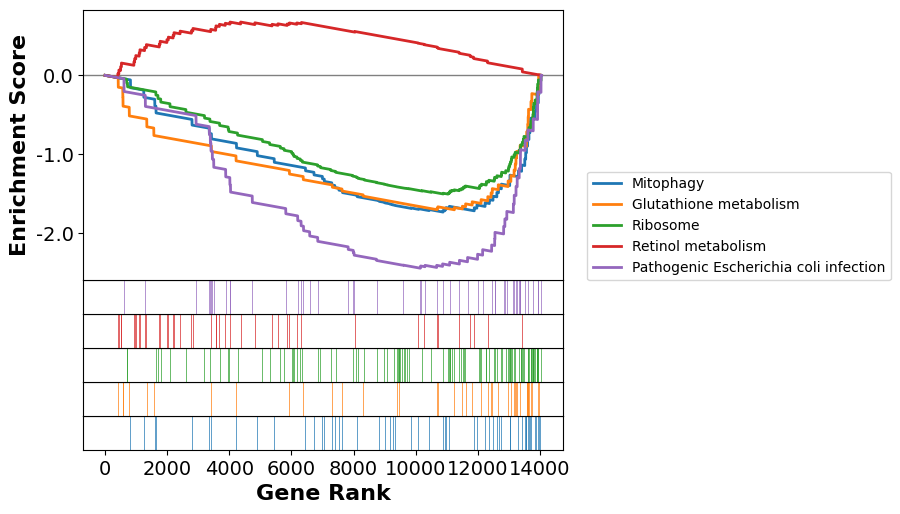

In [29]:
# plot the GSEA curves
terms = gs_res.res2d.Term
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

[]

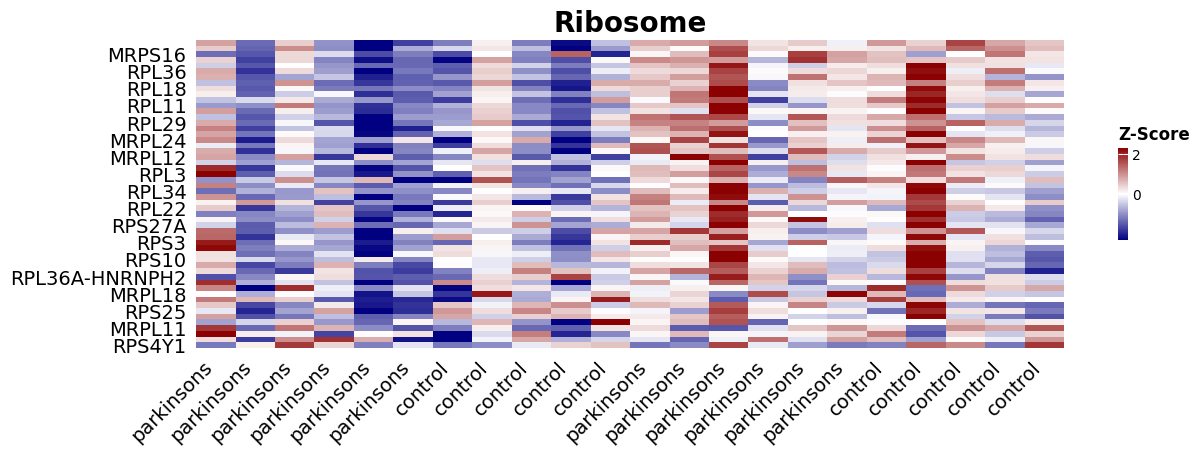

In [30]:
from gseapy import heatmap
# plotting heatmap
i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))
# label the x axis with the class label of the sample
ax.set_xticklabels(classes,rotation=45,ha='right')
ax.plot()

[Text(0.5, 0, 'parkinsons'),
 Text(1.5, 0, 'parkinsons'),
 Text(2.5, 0, 'parkinsons'),
 Text(3.5, 0, 'parkinsons'),
 Text(4.5, 0, 'parkinsons'),
 Text(5.5, 0, 'parkinsons'),
 Text(6.5, 0, 'control'),
 Text(7.5, 0, 'control'),
 Text(8.5, 0, 'control'),
 Text(9.5, 0, 'control'),
 Text(10.5, 0, 'control'),
 Text(11.5, 0, 'parkinsons'),
 Text(12.5, 0, 'parkinsons'),
 Text(13.5, 0, 'parkinsons'),
 Text(14.5, 0, 'parkinsons'),
 Text(15.5, 0, 'parkinsons'),
 Text(16.5, 0, 'parkinsons'),
 Text(17.5, 0, 'control'),
 Text(18.5, 0, 'control'),
 Text(19.5, 0, 'control'),
 Text(20.5, 0, 'control'),
 Text(21.5, 0, 'control')]

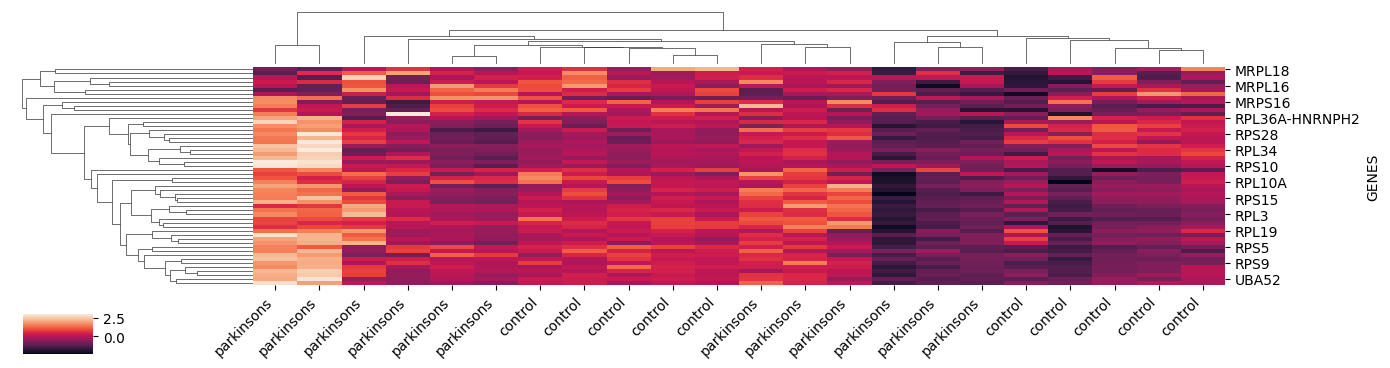

In [31]:
from seaborn import clustermap
# clustermap
i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
# ax = clustermap(data = gs_res.heatmat.loc[genes], z_score=0, figsize=(14,4),metric='correlation',method='average')
ax = clustermap(
    data = gs_res.heatmat.loc[genes],
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=0,
    figsize=(14, 4),
    dendrogram_ratio=0.2,
    colors_ratio=0.03,
    cbar_pos=(0.02, 0.1, 0.05, 0.1),
    tree_kws=None)

# label the x axis with the class label of the sample
ax.ax_heatmap.set_xticklabels(classes,rotation=45,ha='right')

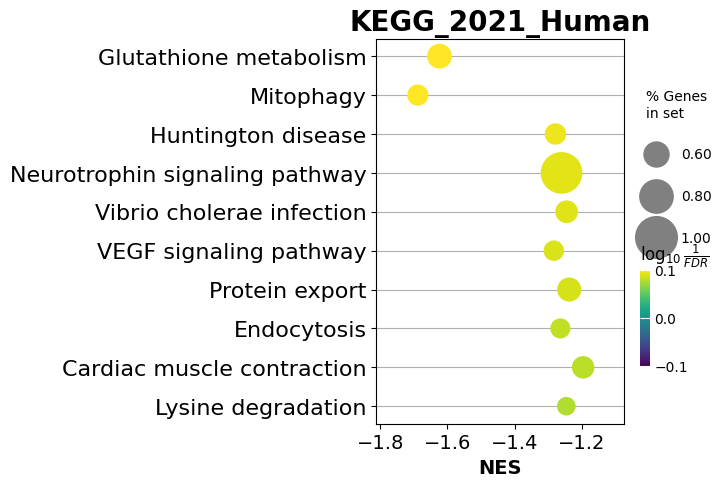

In [32]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d,
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=1)

##### Sparsification on weighted network

weighted based on methylation values

In [ ]:
# def get_weighted_network(G, PPIs_df, scores):

#     # Create a copy of the graph to avoid modifying the original
#     G_weighted = G.copy()
    
#     # Iterate over each score to update/add weighted edges
#     for score in scores:
#         for node1, node2, weight in zip(PPIs_df['preferredName_A'], PPIs_df['preferredName_B'], PPIs_df[score]):
#             # Convert weight to float to ensure proper handling of numerical operations
#             weight = float(weight)
            
#             # Check if the edge already exists
#             if G_weighted.has_edge(node1, node2):
#                 # Update the existing edge with new weights
#                 G_weighted[node1][node2][score] = weight
#                 G_weighted[node1][node2][score + '_reverse'] = 1 - weight
#             else:
#                 # Add new edge with initial weights
#                 G_weighted.add_edge(node1, node2, **{score: weight, score + '_reverse': 1 - weight})
    
#     return G_weighted


In [ ]:
scores = ['ascore', 'tscore', 'escore']

G_weighted = get_weighted_network(G, PPIs_df, scores)

NameError: name 'get_weighted_network' is not defined